## Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Picpay'

In [ ]:
import sys
sys.path.append(path)

## Imports

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import ks_2samp
import shap
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

## Funções

In [ ]:
from functions import calculate_psi, calculate_ks

## Base

In [ ]:
base = pd.read_csv(f'{path}/base_modelo.csv').fillna(-999999999)
base['VAR_32'] = (base['VAR_32']*1000).round(2)
base['VAR_60'] = (base['VAR_60']*1000).round(2)
base

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,1,201404,0,0.0,0.0,0.0,0.0,1.245400e+02,3277.0,5.198000e+01,...,1.563800e+02,7.520000e+00,0.0,151.0,0.0,3.0,4.778400e+02,1.730600e+02,0.000000e+00,3.0
1,2,201407,0,64.0,0.0,2.0,1.0,4.792000e+01,2443.0,8.472000e+01,...,7.078400e+02,-1.000000e+09,-999999999.0,187.0,-999999999.0,-999999999.0,-1.000000e+09,1.846900e+02,5.400000e+01,-999999999.0
2,3,201405,0,99.0,2.0,2.0,2.0,8.038000e+01,1824.0,2.663000e+01,...,4.718600e+02,-1.000000e+09,-999999999.0,96.0,-999999999.0,-999999999.0,-1.000000e+09,7.320000e+02,1.219800e+02,-999999999.0
3,4,201412,0,0.0,0.0,0.0,0.0,1.058000e+01,3796.0,-1.000000e+09,...,1.199600e+02,2.300000e+01,0.0,417.0,0.0,0.0,-1.000000e+09,-1.000000e+09,0.000000e+00,0.0
4,5,201403,1,0.0,0.0,0.0,0.0,7.046000e+01,437.0,4.069000e+01,...,-1.000000e+09,-1.000000e+09,0.0,75.0,0.0,0.0,9.144500e+02,-1.000000e+09,-1.000000e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10733,10734,201406,0,44.0,0.0,0.0,1.0,1.074900e+02,515.0,1.833600e+02,...,-1.000000e+09,-1.000000e+09,-999999999.0,-67.0,-999999999.0,-999999999.0,-1.000000e+09,-1.000000e+09,-1.000000e+09,-999999999.0
10734,10735,201407,0,0.0,0.0,0.0,0.0,3.998000e+01,1029.0,-1.000000e+09,...,2.030700e+02,-1.000000e+09,2.0,404.0,2.0,2.0,3.243100e+02,0.000000e+00,6.111000e+01,2.0
10735,10736,201403,1,169.0,3.0,1.0,2.0,1.050800e+02,819.0,4.928000e+01,...,2.600000e+02,4.190000e+00,3.0,7.0,3.0,3.0,4.191600e+02,4.201600e+02,0.000000e+00,3.0
10736,10737,201402,1,46.0,0.0,0.0,1.0,2.657900e+02,1740.0,-1.000000e+09,...,4.477700e+02,-1.000000e+09,-999999999.0,6.0,-999999999.0,-999999999.0,-1.000000e+09,3.580800e+02,9.291000e+01,-999999999.0


In [ ]:
ident = ['id', 'safra']
target = ['y']

variaveis = ['VAR_6',
'VAR_9',
'VAR_17',
'VAR_53',
'VAR_72',
'VAR_65',
'VAR_54',
'VAR_30',
'VAR_60',
'VAR_38',
'VAR_7',
'VAR_52',
'VAR_58',
'VAR_35',
'VAR_34',
'VAR_24',
'VAR_76',
'VAR_11',
'VAR_59',
'VAR_8',
'VAR_13',
'VAR_45',
'VAR_39',
'VAR_32']

In [ ]:
for var in variaveis:
  base[var] = base[var].astype(float)

## Definições Iniciais

- Treino: Janeiro a Setembro/2014 (201401-201409)
- Teste: Outubro/2014 (201410)
- Validação: Novembro/2014 (201411)

In [ ]:
train_init, train_end = 201401, 201409
test_init, test_end = 201410, 201410
val_init, val_end = 201411, 201411

In [ ]:
base_treino = base[base['safra'].between(train_init, train_end)]
base_teste = base[base['safra'].between(test_init, test_end)]
base_validacao = base[base['safra'].between(val_init, val_end)]

In [ ]:
X_train, y_train = base_treino[variaveis], base_treino[target]
X_test, y_test = base_teste[variaveis], base_teste[target]
X_val, y_val = base_validacao[variaveis], base_validacao[target]

## Optimização de Hiperparâmetros

In [ ]:
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(random_state=13, **params)
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)

    return {'loss': -auc, 'status': STATUS_OK}

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.01), np.log(10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha' : hp.uniform('lambda_l1', 0, 10),
    'reg_lambda' : hp.uniform('lambda_l2', 0, 10),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'objective': 'binary:logistic'
}

In [ ]:
trials = Trials()

In [ ]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(13)
)

100%|██████████| 50/50 [00:39<00:00,  1.27trial/s, best loss: -0.7287737710092321]


In [ ]:
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])

In [ ]:
# best = {'colsample_bytree': 0.7128365907074751, 'lambda_l1': 8.104720609529117, 'lambda_l2': 3.849767535486984, 'learning_rate': 0.021168898337406768,
#         'max_depth': 3, 'min_child_weight': 0.01013849628964554, 'n_estimators': 92, 'scale_pos_weight': 8.504644344680393, 'subsample': 0.6852541877038427}

In [ ]:
print("Melhores hiperparâmetros encontrados:")
print(best)

Melhores hiperparâmetros encontrados:
{'colsample_bytree': 0.7128365907074751, 'lambda_l1': 8.104720609529117, 'lambda_l2': 3.849767535486984, 'learning_rate': 0.021168898337406768, 'max_depth': 3, 'min_child_weight': 0.01013849628964554, 'n_estimators': 92, 'scale_pos_weight': 8.504644344680393, 'subsample': 0.6852541877038427}


## Treino do Modelo

In [ ]:
best_model = XGBClassifier(random_state=13, **best)
best_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7128365907074751, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda_l1=8.104720609529117,
              lambda_l2=3.849767535486984, learning_rate=0.021168898337406768,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0.01013849628964554, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=92,
              n_jobs=None, ...)

In [ ]:
y_test_prob = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_test_prob)

y_val_prob = best_model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_val_prob)


In [ ]:
print(f"AUC no Conjunto de Teste: {auc_test:.4f}")
print(f"AUC no conjunto de Validação: {auc_val:.4f}")

AUC no Conjunto de Teste: 0.7257
AUC no conjunto de Validação: 0.7274


In [ ]:
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]
y_val_prob = best_model.predict_proba(X_val)[:, 1]

In [ ]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred = (y_test_prob >= thresh).astype(int)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

In [ ]:
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Melhor Threshold: {best_threshold:.2f}")
print(f"Melhor F1 Score: {best_f1:.4f}")

Melhor Threshold: 0.72
Melhor F1 Score: 0.5464


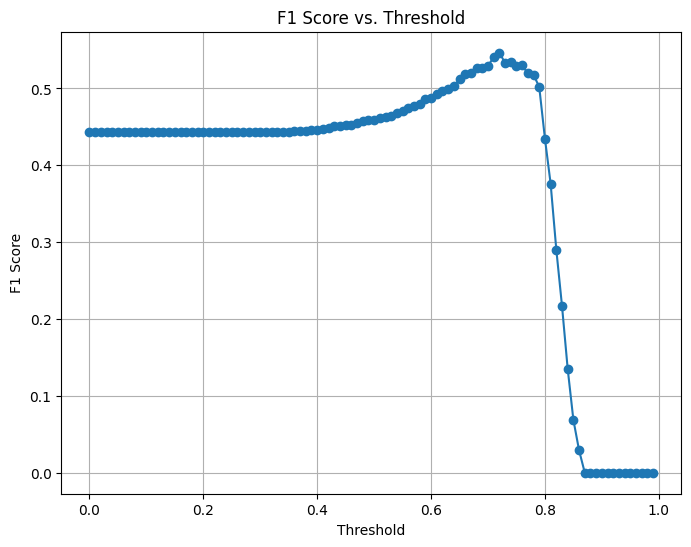

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.show()

In [ ]:
y_train_pred = (y_train_prob >= best_threshold).astype(int)
y_test_pred = (y_test_prob >= best_threshold).astype(int)
y_val_pred = (y_val_prob >= best_threshold).astype(int)

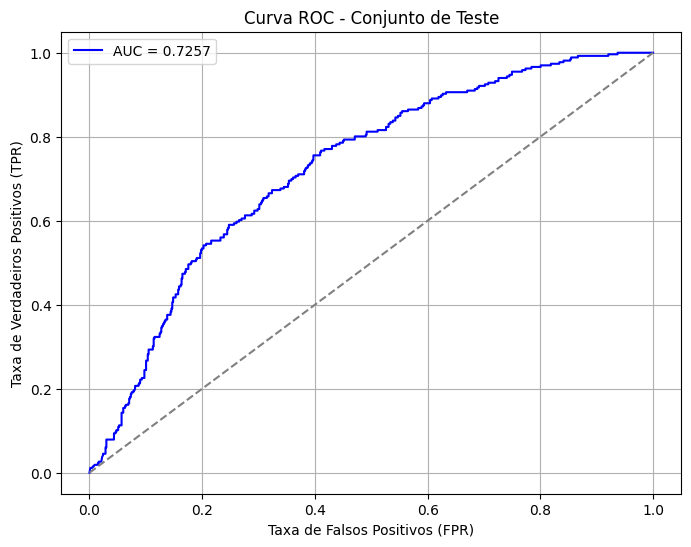

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Teste")
plt.legend()
plt.grid(True)
plt.show()

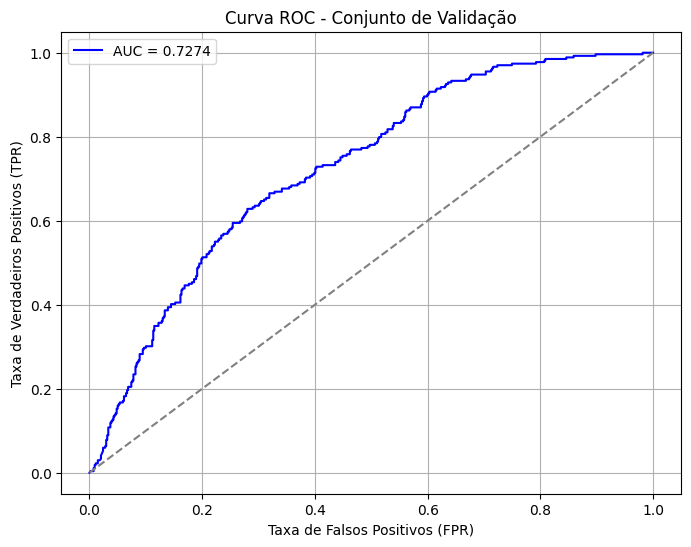

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Validação")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ks_train = calculate_ks(y_train.values.reshape(-1), y_train_prob)
ks_test = calculate_ks(y_test.values.reshape(-1), y_test_prob)
ks_val  = calculate_ks(y_val.values.reshape(-1),  y_val_prob)

In [ ]:
ks_values = [ks_train, ks_test, ks_val]
groups = ['Treino', 'Teste', 'Validação']

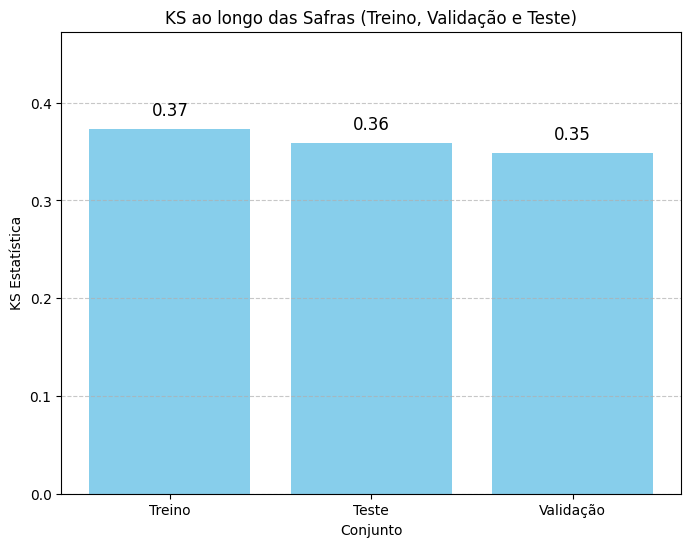

In [ ]:
plt.figure(figsize=(8, 6))
bars = plt.bar(groups, ks_values, color='skyblue')
plt.xlabel("Conjunto")
plt.ylabel("KS Estatística")
plt.title("KS ao longo das Safras (Treino, Validação e Teste)")
for bar, ks_val in zip(bars, ks_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{ks_val:.2f}",
             ha='center', va='bottom', fontsize=12)

plt.ylim(0, max(ks_values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
s1 = sorted(base_treino["safra"].unique())
s2 = sorted(base_teste["safra"].unique())
s3 = sorted(base_validacao["safra"].unique())

safras = s1+s2+s3

ks_values = []

for safra in safras:
    y_true = base[base["safra"] == safra]["y"].values
    X_data = base[base["safra"] == safra][variaveis]

    y_pred_prob = best_model.predict_proba(X_data)[:, 1]

    y_pred_0 = y_pred_prob[y_true == 0]
    y_pred_1 = y_pred_prob[y_true == 1]

    if len(y_pred_0) > 0 and len(y_pred_1) > 0:
        ks_stat, _ = ks_2samp(y_pred_0, y_pred_1)
    else:
        ks_stat = np.nan

    ks_values.append(ks_stat)

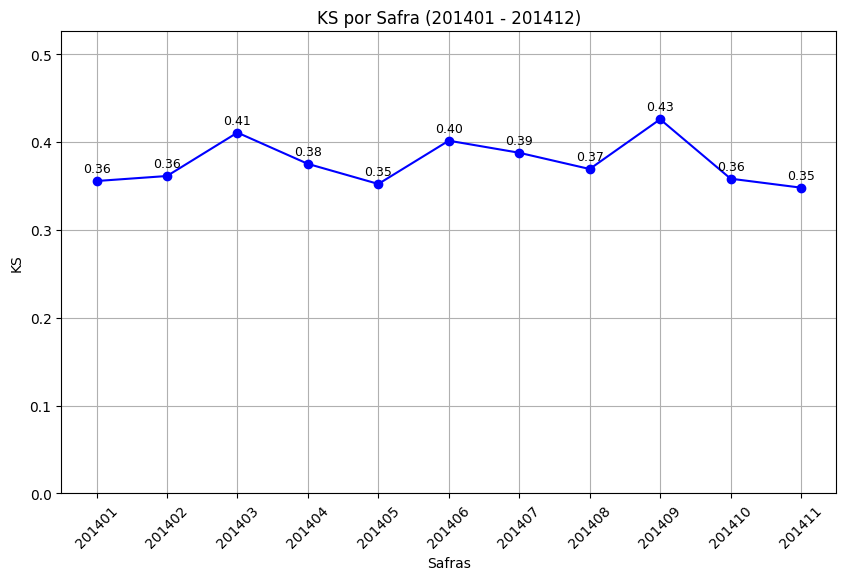

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([str(s) for s in safras], ks_values, marker='o', linestyle='-', color='b')
plt.xlabel("Safras")
plt.ylabel("KS")
plt.title("KS por Safra (201401 - 201412)")
plt.xticks(rotation=45)
plt.ylim(0, max(ks_values) + 0.1)
plt.grid(True)
for x, y in zip([str(s) for s in safras], ks_values):
    plt.text(x, y + 0.01, f"{y:.2f}", ha='center', fontsize=9)
plt.show()

In [ ]:
cm = confusion_matrix(y_val, y_val_pred)
print("Matriz de Confusão (com best_threshold):")
print(cm)

print("\nRelatório de Classificação (com best_threshold):")
print(classification_report(y_val, y_val_pred))

Matriz de Confusão (com best_threshold):
[[317 222]
 [ 73 196]]

Relatório de Classificação (com best_threshold):
              precision    recall  f1-score   support

           0       0.81      0.59      0.68       539
           1       0.47      0.73      0.57       269

    accuracy                           0.63       808
   macro avg       0.64      0.66      0.63       808
weighted avg       0.70      0.63      0.65       808



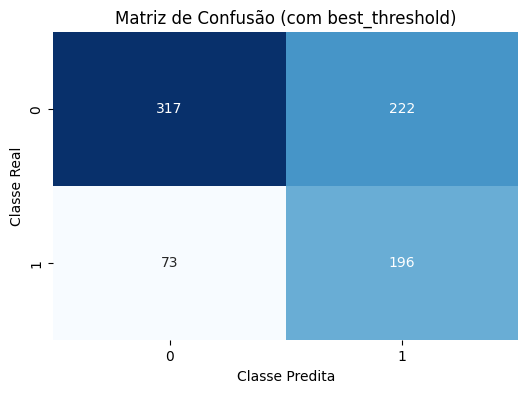

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão (com best_threshold)")
plt.show()

In [ ]:
booster = best_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df

,Feature,Importance
22,VAR_32,153.417374
0,VAR_6,129.155609
1,VAR_9,100.162041
2,VAR_17,96.388588
8,VAR_60,70.306511
7,VAR_30,65.269325
3,VAR_53,64.978951
6,VAR_54,64.436485
5,VAR_65,59.383869
12,VAR_35,49.079453


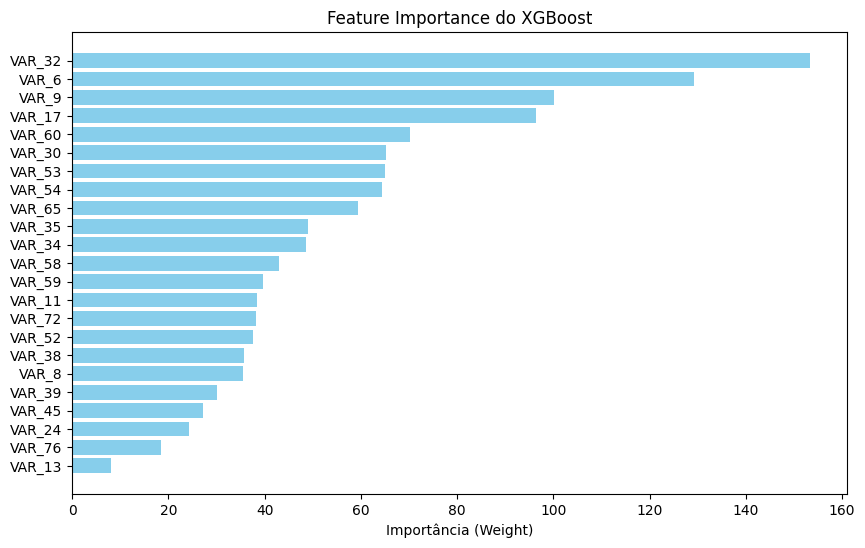

In [ ]:
importance_df.sort_values(by='Importance', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importância (Weight)")
plt.title("Feature Importance do XGBoost")
plt.show()

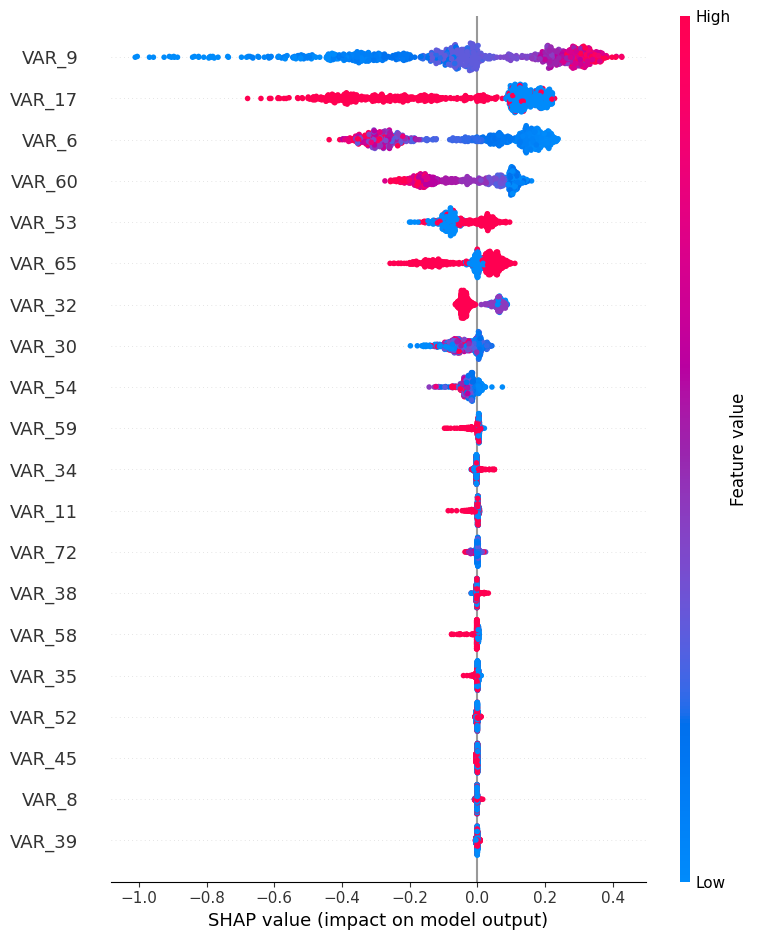

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

# Monitoramento

In [ ]:
psi_teste = {var: calculate_psi(base_treino[var].dropna(), base_teste[var].dropna()) for var in variaveis}
psi_val = {var: calculate_psi(base_treino[var].dropna(), base_validacao[var].dropna()) for var in variaveis}

In [ ]:
psi_df = pd.DataFrame({'Teste': psi_teste, 'Validacao': psi_val})
psi_df.sort_values('Teste', ascending=False)

,Teste,Validacao
VAR_32,0.03,0.05
VAR_9,0.00,0.00
VAR_39,0.00,0.00
VAR_45,0.00,0.00
VAR_13,0.00,0.00
VAR_8,0.00,0.00
VAR_59,0.00,0.00
VAR_11,0.00,0.00
VAR_76,0.00,0.00
VAR_24,0.00,0.00
